### Reference  

[1] Programming Datascience and Others, Instance Segmentation in PyTorch | Mask RCNN, https://youtu.be/f8iiTSCZ9FU

---
### Question
1. Why transform into numpy arrays before doing any manipulation? Can't you use the tensor directly?

In [ ]:
import torch
import torchvision

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

91

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "測試圖片/For training/data1/original_pic" 
IMAGE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
IMAGES = os.listdir(IMAGE_PATH)

In [ ]:
import PIL
import torchvision.transforms as T
import numpy as np
import random

In [ ]:
number_of_images = len(os.listdir(IMAGE_PATH))
print("There are", number_of_images, "images in the image data folder now.")

There are 163 images in the image data folder now.


In [ ]:
def infer_and_return_masks_and_boxes_and_stuff(img_path, threshold = 0.5):
    img = PIL.Image.open(img_path)
    
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.cuda()
    
    prediction = model([img])
    print(f"This image {img_path} contains {prediction[0]['masks'].shape[0]} object(s).")
    print(f"Total mask shape: {list(prediction[0]['masks'].shape)}")
    
    prediction_score = list(prediction[0]['scores'].detach().cpu().numpy())
    prediction_t = [prediction_score.index(x) for x in prediction_score if x > threshold][-1]
    masks = (prediction[0]['masks'] > 0.5).detach().squeeze().cpu().numpy()
    prediction_classes = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(prediction[0]['labels'].detach().cpu().numpy())]
    prediction_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(prediction[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:prediction_t+1]
    prediction_boxes = prediction_boxes[:prediction_t+1]
    prediction_classes = prediction_classes[:prediction_t+1]
    print(f"Show only {prediction_t+1} masks (by applying threshold = {threshold}).")

    return masks, prediction_boxes, prediction_classes

In [ ]:
def random_color_masks(uncolored_mask):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(uncolored_mask).astype(np.uint8)
  g = np.zeros_like(uncolored_mask).astype(np.uint8)
  b = np.zeros_like(uncolored_mask).astype(np.uint8)
  r[uncolored_mask==1], g[uncolored_mask==1], b[uncolored_mask==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [ ]:
# holy shit why can't I just use PIL to edit images???
import cv2

def do_seg_and_draw_masks(img_path, threshold = 0.5, rect_th = 3, text_size = 3, text_th = 3):
    masks, boxes, classes = infer_and_return_masks_and_boxes_and_stuff(img_path, threshold = threshold)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    for i in range(len(masks)):
        rgb_mask = random_color_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, classes[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
    
    return img

(RANDOMIZED) Reading file: 001-1.0004.jpeg


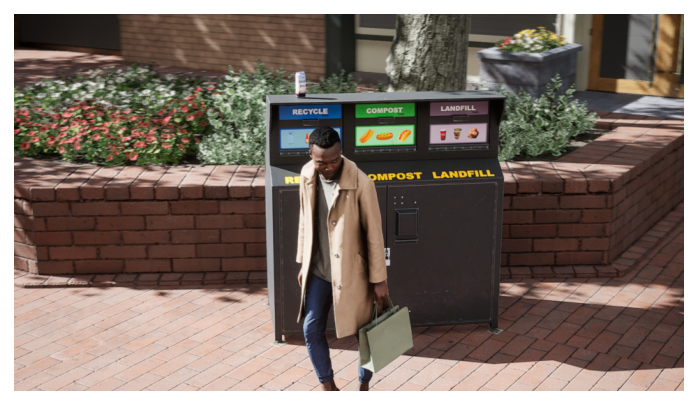

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

temp_image_filename = IMAGES[random.randint(0, number_of_images)]
print("(RANDOMIZED) Reading file:", temp_image_filename)
img = PIL.Image.open(os.path.join(IMAGE_PATH, temp_image_filename))
plt.axis('off')
plt.imshow(img)

This image drive/My Drive/測試圖片/For training/data1/original_pic/001-1.0004.jpeg contains 18 object(s).
Total mask shape: [18, 1, 540, 960]
Show only 5 masks (by applying threshold = 0.5).


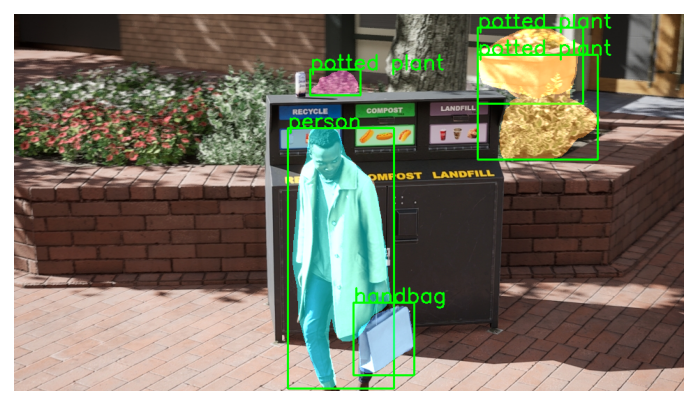

In [ ]:
threshold = 0.5
processed_img = do_seg_and_draw_masks(img_path = os.path.join(IMAGE_PATH, temp_image_filename), threshold = threshold, rect_th = 2, text_size = 1, text_th = 2)

plt.axis('off')
plt.imshow(processed_img)

### Try it yourself
I don't think it would be too hard, right?
right?


#### Just some imports ZZZ

In [ ]:
import torch
import torchvision
import numpy as np

#### important hyperparameters

In [ ]:
I_want_to_load = True
I_want_to_train = True

import datetime
datecode = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

different_data_folder_name = "For training"
which_data_folder = 0 # 4 folders as of now

MODEL_MOTHER_PATH = "/content/drive/MyDrive/trained model/UNet"
device = ('cuda' if torch.cuda.is_available() else 'cpu')
input_image_shape = (544, 960)
n_classes = 1
n_channels = 64

train_test_split_ratio = 0.1
batch_size = 4

learning_rate = 0.001
max_epoch = 10

inferred_mask_threshold = 0.5

#### 1. Get data from google drive and load it

In [ ]:
import google
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# which_data_folder = 3

# different_data_folder_name = "For training"
all_data_folder = os.path.join("drive", "MyDrive", different_data_folder_name) # change this path for different account, since google drive can no longer mount drives of other accounts
data_folders = os.listdir(all_data_folder)
data_folders.remove("ReadMe.gdoc")
data_folders.remove("CreateBoundingBox.exe")
mode = {"data" : "original_pic", "targets" : "processed"}

for i in data_folders:
    IMAGE_PATH = os.path.join(all_data_folder, i, mode["data"])
    MASK_PATH = os.path.join(all_data_folder, i, mode["targets"])
    IMAGES = sorted(os.listdir(IMAGE_PATH))
    MASKS = sorted(os.listdir(MASK_PATH))

    print("There are", len(IMAGES), f"images from the \"{i}/{mode['data']}\" folder.")
    print("There are", len(MASKS), f"images from the \"{i}/{mode['targets']}\" folder.")

IMAGE_PATH = os.path.join(all_data_folder, data_folders[which_data_folder], mode["data"])
MASK_PATH = os.path.join(all_data_folder, data_folders[which_data_folder] , mode["targets"])
IMAGES = sorted([os.path.join(IMAGE_PATH, temp_name) for temp_name in os.listdir(IMAGE_PATH)])
MASKS = sorted([os.path.join(MASK_PATH, temp_name) for temp_name in os.listdir(MASK_PATH)])
print(f"\nUsing {len(IMAGES)} images from the \"{data_folders[which_data_folder]}\" folder.")

There are 150 images from the "data2/original_pic" folder.
There are 150 images from the "data2/processed" folder.
There are 163 images from the "data1/original_pic" folder.
There are 163 images from the "data1/processed" folder.
There are 150 images from the "data3/original_pic" folder.
There are 150 images from the "data3/processed" folder.
There are 1001 images from the "data4/original_pic" folder.
There are 1001 images from the "data4/processed" folder.

Using 150 images from the "data2" folder.


In [ ]:
import PIL

class SegmentationDatasetForUNet(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transforms = None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_path[idx])
        mask = PIL.Image.open(self.mask_path[idx]).convert("L")

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return (image, mask)

In [ ]:
from sklearn.model_selection import train_test_split

split = train_test_split(IMAGES, MASKS, test_size=train_test_split_ratio, random_state=69420)
train_images, val_images = split[:2]
train_masks, val_masks = split[2:]

In [ ]:
# batch_size = 4
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(input_image_shape), 
                                             torchvision.transforms.ToTensor()])

train_dataset = SegmentationDatasetForUNet(image_path = train_images, mask_path = train_masks, transforms = transforms)
val_dataset = SegmentationDatasetForUNet(image_path = val_images, mask_path = val_masks, transforms = transforms)

train_data_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_data_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size = batch_size)

#### 2. Set up model

In [ ]:
#U-Net model
class DoubleConv(torch.nn.Module):
    """(Conv2D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #torch.nn.BatchNorm2d(out_channels),
            torch.nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #torch.nn.BatchNorm2d(out_channels),
            torch.nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            torch.nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)
    
class Down(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.MaxPool2d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

class Up(torch.nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = torch.nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Out(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)
    
class UNet2d(torch.nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

#### 3. Do train!

In [ ]:
torch.cuda.empty_cache()
# device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet2d(in_channels = 3, n_classes = n_classes, n_channels = n_channels).to(device)
print(f"There are {sum(p.numel() for p in model.parameters())} parameters in this U-Net model!")

There are 13395329 parameters in this U-Net model!


##### Training block. This is kinda shitty

In [ ]:
if I_want_to_load:
    # load pretrained model
    print("loading pretrained model...")

    list_of_models = [os.path.join(MODEL_MOTHER_PATH, x) for x in os.listdir(MODEL_MOTHER_PATH)]
    latest_model = max(list_of_models, key = os.path.getctime)

    model = UNet2d(in_channels = 3, n_classes = n_classes, n_channels = n_channels).to(device)
    try:
        model.load_state_dict(torch.load(latest_model))
        print(f"Pretrained model ({latest_model}) loaded successfully!")
    except:
        print("Loading pretrained model failed\nYou created a new model with different structure, loading failed, using random weight...")

else:
    # instantiate new model
    print("Instantiating new model...")

    model = UNet2d(in_channels = 3, n_classes = n_classes, n_channels = n_channels).to(device)

loading pretrained model...
Pretrained model (/content/drive/MyDrive/trained model/UNet/UNET_C1N64_20220625_052935.pt) loaded successfully!


In [ ]:
import time

if I_want_to_train:
    print("Initializing...")
    
    # initialize some stuff
    # learning_rate = 0.01
    # max_epoch = 10
    iteration_per_epoch = len(train_data_dataloader)

    model.train()

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.333, patience = 10, verbose = True)

    # do train
    print("Start training... (You can go to sleep now)")
    train_start_time = time.time()
    for epoch in range(max_epoch):
        for iteration, (images, masks) in enumerate(train_data_dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            # scheduler.step(loss)
            
            if (iteration + 1) % 10 == 0:
                print(f"EPOCH {epoch + 1}/{max_epoch}, ITERATION {iteration + 1}/{len(train_data_dataloader)}, loss = {loss.item():.5f}")
    train_end_time = time.time()
    print("Training complete!!!")
    print(f"Time elapsed: {train_end_time - train_start_time:.2f} seconds")

    MODEL_NAME = "UNET_" + ("C" + str(n_classes)) + ("N" + str(n_channels)) + "_" + str(datecode) + ".pt"
    MODEL_PATH = os.path.join("/content/drive/MyDrive/trained model/UNet", MODEL_NAME)
    torch.save(model.state_dict(), MODEL_PATH)

Initializing...
Start training... (You can go to sleep now)
EPOCH 1/10, ITERATION 10/34, loss = 0.04228
EPOCH 1/10, ITERATION 20/34, loss = 0.02171
EPOCH 1/10, ITERATION 30/34, loss = 0.02088
EPOCH 2/10, ITERATION 10/34, loss = 0.01167
EPOCH 2/10, ITERATION 20/34, loss = 0.01167
EPOCH 2/10, ITERATION 30/34, loss = 0.01622
EPOCH 3/10, ITERATION 10/34, loss = 0.01008
EPOCH 3/10, ITERATION 20/34, loss = 0.00992
EPOCH 3/10, ITERATION 30/34, loss = 0.01127
EPOCH 4/10, ITERATION 10/34, loss = 0.01871
EPOCH 4/10, ITERATION 20/34, loss = 0.00745
EPOCH 4/10, ITERATION 30/34, loss = 0.00992
EPOCH 5/10, ITERATION 10/34, loss = 0.01921
EPOCH 5/10, ITERATION 20/34, loss = 0.00694
EPOCH 5/10, ITERATION 30/34, loss = 0.01046
EPOCH 6/10, ITERATION 10/34, loss = 0.00824
EPOCH 6/10, ITERATION 20/34, loss = 0.00718
EPOCH 6/10, ITERATION 30/34, loss = 0.00792
EPOCH 7/10, ITERATION 10/34, loss = 0.00532
EPOCH 7/10, ITERATION 20/34, loss = 0.00761
EPOCH 7/10, ITERATION 30/34, loss = 0.00692
EPOCH 8/10, ITER

#### 4. Inference

##### Useful functions

In [ ]:
import random

def random_color_masks(uncolored_mask):
    # I will copy a list of colors here
    colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(uncolored_mask).astype(np.uint8)
    g = np.zeros_like(uncolored_mask).astype(np.uint8)
    b = np.zeros_like(uncolored_mask).astype(np.uint8)
    r[uncolored_mask==1], g[uncolored_mask==1], b[uncolored_mask==1] = colors[random.randint(0, 10)]
    colored_mask = np.stack([r,g,b], axis=2)
    return colored_mask

In [ ]:
import cv2

def infer_and_draw_masks_and_stuff(img_path = None, img = None, threshold = 0.5, transforms = None):
    if (img_path is None) and (img is None):
        print("No image path or image provided!")
        return None

    elif (img_path is not None) and (img is None):
        temp = PIL.Image.open(img_path)
        temp = torch.unsqueeze(transforms(temp), 0).cuda()
        prediction = model(temp)
        mask = (prediction[0][0] > threshold).detach().squeeze().cpu().numpy()
        rgb_mask = random_color_masks(mask)

        temp = cv2.imread(img_path)
        temp = temp[:,:,::-1] # BGR to RGB, I don't know why openCV likes to fuck with us so much
        temp = cv2.resize(temp, (960, 544))
        temp = cv2.addWeighted(temp, 1, rgb_mask, 0.5, 0)
        
    elif (img is not None) and (img_path is None):
        img_tensor = torch.tensor(img, dtype = torch.float32, device = device) / 255
        img_tensor = torch.permute(img_tensor, (2, 0, 1))
        img_tensor = torch.unsqueeze(img_tensor, 0)

        prediction = model(img_tensor)
        mask = (prediction[0][0] > threshold).detach().squeeze().cpu().numpy()
        rgb_mask = random_color_masks(mask)
        temp = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
    else:
        print("This function only needs either image path or image!")
        return None

    if temp is not None:
        plt.axis('off')
        plt.title("Model prediction mask")
        plt.imshow(temp)

##### Using our datasets


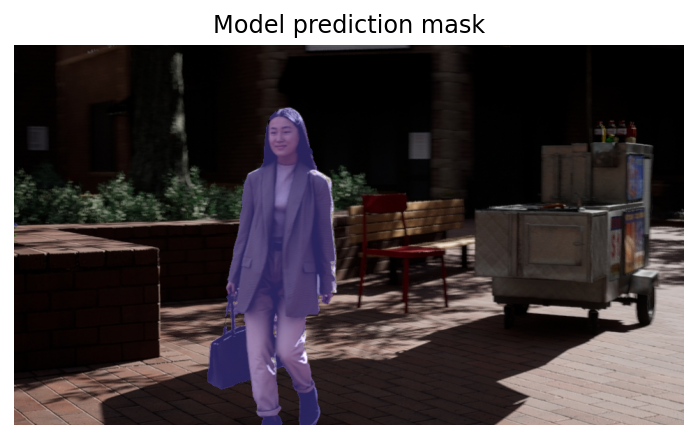

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high resolution images

model.eval()

# inferred_mask_threshold = 0.5
infer_and_draw_masks_and_stuff(IMAGES[random.randint(0, len(IMAGES))], threshold = inferred_mask_threshold, transforms = transforms)

##### Prepare for MS COCO dataset

In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pycocotools.coco
import os

which_COCO_annotations_file_name = "instances_val2017.json"

COCO_annotations_file_path = os.path.join("drive", "MyDrive", which_COCO_annotations_file_name)
COCO = pycocotools.coco.COCO(COCO_annotations_file_path)

loading annotations into memory...
Done (t=1.74s)
creating index...
index created!


In [ ]:
what_class_or_classes_do_you_want = "person"

class_id = COCO.getCatIds(what_class_or_classes_do_you_want)
all_ids_of_images_containing_person = COCO.getImgIds(catIds = class_id)
all_images_containing_person_json = COCO.loadImgs(ids = all_ids_of_images_containing_person)
print(f"There are {len(all_images_containing_person_json)} images that contain class \'{what_class_or_classes_do_you_want}\' in the \"{which_COCO_annotations_file_name}\" annotaion file.")

There are 2693 images that contain class 'person' in the "instances_val2017.json" annotaion file.


##### Using MS coco dataset

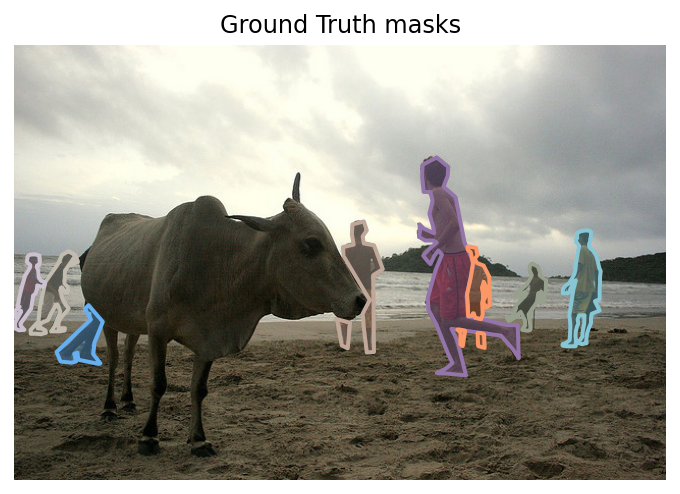

In [ ]:
import skimage.io

how_many_pictures_are_in_the_class_sub_dataset = len(all_images_containing_person_json)
random_image_id = np.random.randint(0, how_many_pictures_are_in_the_class_sub_dataset)

img = skimage.io.imread(all_images_containing_person_json[random_image_id]['coco_url'])
img_all_annotations = COCO.loadAnns(COCO.getAnnIds(imgIds = all_images_containing_person_json[random_image_id]['id']))
img_certain_class_annotations = []
for annotation in img_all_annotations:
    if annotation['category_id'] in set(class_id):
        img_certain_class_annotations.append(annotation)

plt.axis("off")
plt.title("Ground Truth masks")
plt.imshow(img)
# plt.show()
COCO.showAnns(img_certain_class_annotations)

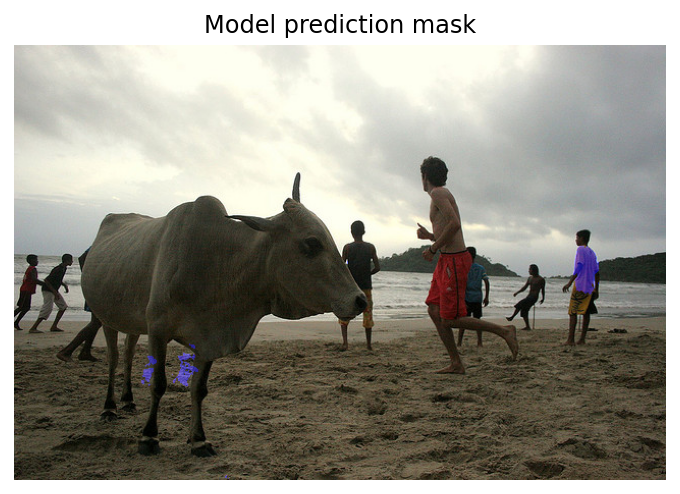

In [ ]:
model.eval()

infer_and_draw_masks_and_stuff(img = img, threshold = inferred_mask_threshold, transforms = transforms)